# Clasificación de imágenes
<FONT SIZE = 4>Haremos uso de la libreria keras la cual es una libreria de redes neuronales que trabaja sobre Tensorflow. Impotamos las librerias necesarias.

In [158]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [159]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

<FONT SIZE = 4>Ahora leemos las imagenes del directorio **MelanomaCNN** y cargamos estas

In [160]:
dirname = os.path.join(os.getcwd())
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /home/juan/Escritorio/MelanomaCNN/Melanoma 50x50/
/home/juan/Escritorio/MelanomaCNN/Melanoma 50x50/Bening 1
/home/juan/Escritorio/MelanomaCNN/Melanoma 50x50/Malignant 2093
Directorios leidos: 2
Imagenes en cada directorio [2094, 2088]
suma Total de imagenes en subdirs: 4182


<FONT SIZE = 4>A cada una de las imágenes cargadas le asignamos una etiqueta la cual no es más que el indice de la lista
*labels*

In [161]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  4182


<FONT SIZE = 4>Creamos una lista cells que simplemente tendra el nombre de los directorios alojados en la carpeta **MelanomaCNN**, los que en este caso seran los tipos de célula ya sean benignas o malignas

In [162]:
cells=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    cells.append(name[len(name)-1])
    indice=indice+1

0 Bening
1 Malignant


<FONT SIZE = 4>Ahora separamos las imagenes en las clases a comparar, es decir malignas (0) y benignas (1). Y convertimos nuestras imágenes en una lista.

In [163]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Buscar los numeros unicos en los labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


<FONT SIZE = 4>Ahora definimos el porcentaje de imágenes que seran usadas para el entrenamiento y el test de cada clase.

In [164]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.15)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (3554, 50, 50, 3) (3554,)
Testing data shape :  (628, 50, 50, 3) (628,)


<FONT SIZE = 4>Mostramos la primera imágen de cada uno de los conjuntos: entrenamiento y test

Text(0.5, 1.0, 'Ground Truth : 0')

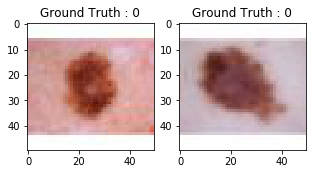

In [165]:
plt.figure(figsize=[5,5])

# Mostrar la primera imagen en el conjunto de entrenamiento
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Mostramos la primera imagen del conunto de test
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

In [166]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [167]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0.]


In [168]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.25, random_state=13)

In [169]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(2665, 50, 50, 3) (889, 50, 50, 3) (2665, 2) (889, 2)


<FONT SIZE = 4>Realizamos el modelo e imprimimos

In [170]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 10 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [171]:
melanoma_model = Sequential()
melanoma_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(50,50,3)))
melanoma_model.add(LeakyReLU(alpha=0.1))
melanoma_model.add(MaxPooling2D((2, 2),padding='same'))
melanoma_model.add(Dropout(0.5))

melanoma_model.add(Flatten())
melanoma_model.add(Dense(32, activation='linear'))
melanoma_model.add(LeakyReLU(alpha=0.1))
melanoma_model.add(Dropout(0.5))
melanoma_model.add(Dense(nClasses, activation='softmax'))

In [172]:
melanoma_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                640032    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32)               

In [173]:
melanoma_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

<FONT SIZE = 4> Entrenamos la red neuronal

In [174]:
#entrenar la red neuronal
melanoma_train = melanoma_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 2665 samples, validate on 889 samples
Epoch 1/10
2665/2665 [==============================] - 12s 5ms/step - loss: 0.8459 - accuracy: 0.4897 - val_loss: 0.6834 - val_accuracy: 0.6434
Epoch 2/10
2665/2665 [==============================] - 11s 4ms/step - loss: 0.6973 - accuracy: 0.5377 - val_loss: 0.6781 - val_accuracy: 0.5489
Epoch 3/10
2665/2665 [==============================] - 12s 4ms/step - loss: 0.6968 - accuracy: 0.5606 - val_loss: 0.6709 - val_accuracy: 0.6490
Epoch 4/10
2665/2665 [==============================] - 11s 4ms/step - loss: 0.6800 - accuracy: 0.5790 - val_loss: 0.6703 - val_accuracy: 0.5084
Epoch 5/10
2665/2665 [==============================] - 12s 4ms/step - loss: 0.6649 - accuracy: 0.5925 - val_loss: 0.6564 - val_accuracy: 0.6355
Epoch 6/10
2665/2665 [==============================] - 11s 4ms/step - loss: 0.6690 - accuracy: 0.6053 - val_loss: 0.6513 - val_accuracy: 0.5917
Epoch 7/10
2665/2665 [==============================] - 12s 4ms/step - loss: 0.6679

<FONT SIZE = 4>En caso de ser necesario reutilizar la red guardamos esta

In [175]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
melanoma_model.save("melanoma_mnist.h5py")

<FONT SIZE = 4>Evaluamos e imprimimos la precisión de la red neuronal

In [176]:
test_eval = melanoma_model.evaluate(test_X, test_Y_one_hot, verbose=1)

628/628 [==============================] - 1s 1ms/step


In [177]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.6277389408676488
Test accuracy: 0.6894904375076294


<FONT SIZE = 4>Mostramos gráficamente el comportamiento de la precision en el entrenamiento de la red

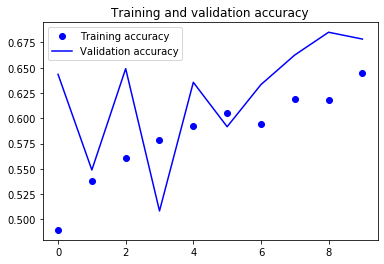

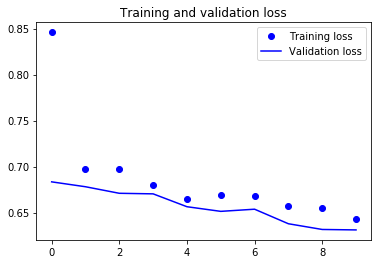

In [178]:
accuracy = melanoma_train.history['accuracy']
val_accuracy = melanoma_train.history['val_accuracy']
loss = melanoma_train.history['loss']
val_loss = melanoma_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<FONT SIZE = 4>Ahora realizamos el test, para clasificar las imágenes que no se usaron en el entrenamiento

In [179]:
predicted_classes2 = melanoma_model.predict(test_X)

In [180]:
predicted_classes=[]
for predicted_melanoma in predicted_classes2:
    predicted_classes.append(predicted_melanoma.tolist().index(max(predicted_melanoma)))
predicted_classes=np.array(predicted_classes)

In [181]:
predicted_classes.shape, test_Y.shape

((628,), (628,))

<FONT SIZE = 4>Evaluamos cuales fueron correctamente clasificadas

Found 433 correct labels


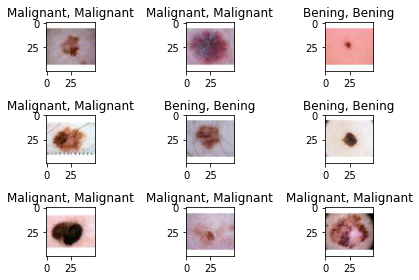

In [182]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(50,50,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(cells[predicted_classes[correct]], cells[test_Y[correct]]))
    plt.tight_layout()

<FONT SIZE = 4>y cuales no

Found 195 incorrect labels


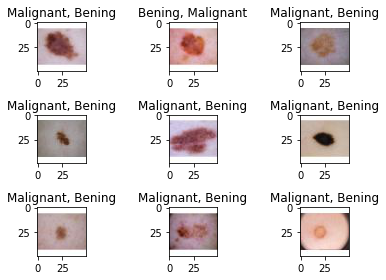

In [183]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(50,50,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(cells[predicted_classes[incorrect]], cells[test_Y[incorrect]]))
    plt.tight_layout()

<FONT SIZE = 4>Así podemos obtener un reporte detallado del trabajo de la red neuronal

In [184]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.73      0.60      0.66       315
     Class 1       0.66      0.78      0.71       313

    accuracy                           0.69       628
   macro avg       0.70      0.69      0.69       628
weighted avg       0.70      0.69      0.69       628



<FONT SIZE = 4>Finalmente la red esra lista para su uso y a continuación se puede probar con imagenes propias.

In [185]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['../lunar2.jpg', '../lunar.jpg']

for filepath in filenames:
    image = plt.imread(filepath,0)
    image_resized = resize(image, (50, 50),anti_aliasing=True,clip=False,preserve_range=True)
    images.append(image_resized)

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = melanoma_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], cells[img_tagged.tolist().index(max(img_tagged))])

../lunar2.jpg Bening
../lunar.jpg Malignant
